In [1]:
from pipeline import Pipeline
from huggingface_hub import hf_hub_download

model_path = hf_hub_download(repo_id="Pikurrot/yolo11n-licenseplates", filename="yolo11n_licenseplates.pt")
pipeline = Pipeline(model_path)

/home/eric/miniconda3/envs/yolo/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Using device cuda


In [2]:
segments = pipeline("images/reduced/")


image 1/12 /media/eric/D/repos/ANPR-GIA/images/reduced/0.jpg: 384x640 1 license_plate, 66.2ms
image 2/12 /media/eric/D/repos/ANPR-GIA/images/reduced/1.jpg: 384x640 1 license_plate, 13.8ms
image 3/12 /media/eric/D/repos/ANPR-GIA/images/reduced/10.jpeg: 480x640 1 license_plate, 31.4ms
image 4/12 /media/eric/D/repos/ANPR-GIA/images/reduced/11.jpeg: 640x480 1 license_plate, 30.8ms
image 5/12 /media/eric/D/repos/ANPR-GIA/images/reduced/2.jpg: 288x640 1 license_plate, 32.9ms
image 6/12 /media/eric/D/repos/ANPR-GIA/images/reduced/3.jpg: 288x640 1 license_plate, 12.3ms
image 7/12 /media/eric/D/repos/ANPR-GIA/images/reduced/4.jpg: 288x640 1 license_plate, 12.9ms
image 8/12 /media/eric/D/repos/ANPR-GIA/images/reduced/5.jpg: 384x640 1 license_plate, 14.5ms
image 9/12 /media/eric/D/repos/ANPR-GIA/images/reduced/6.jpg: 480x640 1 license_plate, 11.2ms
image 10/12 /media/eric/D/repos/ANPR-GIA/images/reduced/7.jpg: 640x640 1 license_plate, 12.2ms
image 11/12 /media/eric/D/repos/ANPR-GIA/images/reduce

In [3]:
from PIL import Image
import os
import matplotlib.pyplot as plt

filenames = os.listdir("images/reduced/")
orig_images = [Image.open(f"images/reduced/{filename}") for filename in filenames]

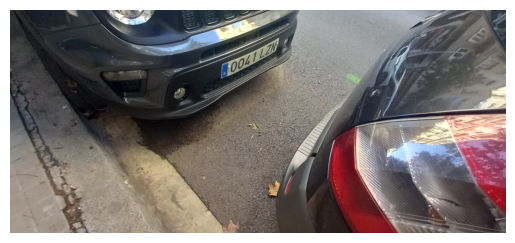

In [4]:
i = 11
plt.imshow(orig_images[i])
plt.axis("off")
plt.show()

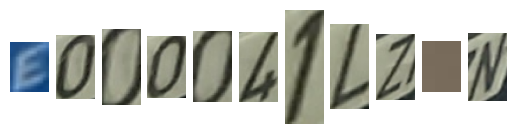

In [5]:
segments0 = segments[i][0]
fig, ax = plt.subplots(1, len(segments0))
for s, segment in enumerate(segments0):
	ax[s].imshow(segment)
	ax[s].axis("off")
plt.show()

---

In [6]:
detections = pipeline.detect("images/reduced/", 640, 0.25, -1)
crops = pipeline.extract_boxes(detections)


image 1/12 /media/eric/D/repos/ANPR-GIA/images/reduced/0.jpg: 384x640 1 license_plate, 14.5ms
image 2/12 /media/eric/D/repos/ANPR-GIA/images/reduced/1.jpg: 384x640 1 license_plate, 13.9ms
image 3/12 /media/eric/D/repos/ANPR-GIA/images/reduced/10.jpeg: 480x640 1 license_plate, 8.8ms
image 4/12 /media/eric/D/repos/ANPR-GIA/images/reduced/11.jpeg: 640x480 1 license_plate, 8.8ms
image 5/12 /media/eric/D/repos/ANPR-GIA/images/reduced/2.jpg: 288x640 1 license_plate, 13.3ms
image 6/12 /media/eric/D/repos/ANPR-GIA/images/reduced/3.jpg: 288x640 1 license_plate, 12.5ms
image 7/12 /media/eric/D/repos/ANPR-GIA/images/reduced/4.jpg: 288x640 1 license_plate, 12.3ms
image 8/12 /media/eric/D/repos/ANPR-GIA/images/reduced/5.jpg: 384x640 1 license_plate, 14.6ms
image 9/12 /media/eric/D/repos/ANPR-GIA/images/reduced/6.jpg: 480x640 1 license_plate, 9.0ms
image 10/12 /media/eric/D/repos/ANPR-GIA/images/reduced/7.jpg: 640x640 1 license_plate, 11.8ms
image 11/12 /media/eric/D/repos/ANPR-GIA/images/reduced/8

In [7]:
from typing import List, Tuple
from PIL import Image, ImageDraw, ImageOps
import numpy as np
import cv2
import pytesseract
import matplotlib.pyplot as plt

pytesseract.pytesseract.tesseract_cmd = r'/usr/bin/tesseract'

# Segment function updated to use the trained model for character recognition
def segment(
            source: List[List[Image.Image]]
    ) -> Tuple[List[List[List[Image.Image]]], List[List[List[Image.Image]]], List[List[List[Tuple[Image.Image, str]]]]]:
    """
    Segment the license plates into individual characters and visualize bounding boxes.

    :param source: Output of the extract_boxes function
    :return: Segments of license plates, visualizations of detected bounding boxes before and after filtering, and final segments with recognized characters.
    """
    segments = []
    visualizations = []
    recognized_characters = []

    for img in source:
        img_segments = []
        img_visualizations = []
        img_recognized = []
        for plate in img:
            plate_segments = []
            plate_visualizations = []
            plate_recognized = []
            
            # Resize the plate to a consistent size
            plate = plate.resize((200, 50))
            
            # Convert to grayscale if not already
            if plate.mode != "L":
                gray = plate.convert("L")
            else:
                gray = plate.copy()
            gray = np.array(gray)
            
            # Preprocess using adaptive thresholding
            blurred = cv2.GaussianBlur(gray, (5, 5), 0)
            thresh = cv2.adaptiveThreshold(blurred, 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C, cv2.THRESH_BINARY, 11, 2)
            
            # Invert the thresholded image to ensure white text on black background
            thresh = cv2.bitwise_not(thresh)
            
            # Find contours
            contours, hierarchy = cv2.findContours(thresh, cv2.RETR_CCOMP, cv2.CHAIN_APPROX_SIMPLE)
            hierarchy = hierarchy[0]
            
            # Create an initial visualization with all bounding boxes
            original_visualization = plate.convert("RGB")
            draw = ImageDraw.Draw(original_visualization)
            for contour in contours:
                x, y, w, h = cv2.boundingRect(contour)
                draw.rectangle([x, y, x + w, y + h], outline="red", width=1)
            plate_visualizations.append(original_visualization)
            
            # Filter contours to remove obvious noise, but retain characters and possible extra regions
            bounding_boxes = []
            for i, contour in enumerate(contours):
                x, y, w, h = cv2.boundingRect(contour)
                aspect_ratio = w / float(h)
                area = w * h
                parent_idx = hierarchy[i][3]
                child_idx = hierarchy[i][2]
                
                # Use relative area to filter contours after resizing plate to a consistent size
                if 0.1 < aspect_ratio < 2.0 and 70 < area < 800:
                    # Check if the contour is not a hole (i.e., not a child of another character)
                    # and if it has no children or its children are significantly smaller
                    is_valid_character = True
                    if parent_idx != -1:
                        # If this contour is a child, it might be a hole, so skip it
                        continue
                    if child_idx != -1:
                        # Iterate over all children and check their area
                        while child_idx != -1:
                            child_area = cv2.contourArea(contours[child_idx])
                            if child_area > 0.5 * area:
                                # If the child area is significant, this means it might not be a hole
                                is_valid_character = False
                                break
                            child_idx = hierarchy[child_idx][0]  # Get the next child
                    
                    if is_valid_character:
                        bounding_boxes.append((x, y, w, h))
            
            # Create a visualization after initial filtering
            filtered_visualization = plate.convert("RGB")
            draw = ImageDraw.Draw(filtered_visualization)
            for x, y, w, h in bounding_boxes:
                draw.rectangle([x, y, x + w, y + h], outline="green", width=1)
            plate_visualizations.append(filtered_visualization)
            
            # Sort from left to right
            bounding_boxes = sorted(bounding_boxes, key=lambda box: box[0])
            
            # Step 2: Apply the trained model to recognize characters in each segment
            for x, y, w, h in bounding_boxes:
                segment = Image.fromarray(gray)
                segment = segment.crop((x, y, x + w, y + h))
                r = w / h
                segment = segment.resize((40, int(40 / r)))

                # binarialize the image
                before = segment.copy()
                _, segment = cv2.threshold(np.array(segment), 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)
                segment = Image.fromarray(segment)

                # place the segment on a black background slightly larger than the original
                background = Image.new('L', (60, int(60 / r)), 255)
                offset = (10, int(10 / r))
                background.paste(segment, offset)
                segment = background     

                # Predict with tessaract
                ocr_result = pytesseract.image_to_data(
                    segment,
                    config='--psm 10 --oem 3 -c tessedit_char_whitelist=0123456789ABCDEFGHIJKLMNOPQRSTUVWXYZ',
                    output_type=pytesseract.Output.DICT
                )
                
                # Filter based on confidence
                confidences = [float(conf) for conf in ocr_result['conf']]# if conf != '-1']
                if confidences and max(confidences) >= -1: # >= 50:
                    recognized_text = ocr_result['text'][np.argmax(confidences)].strip()
                    plate_segments.append(segment)
                    plate_recognized.append((segment, recognized_text, max(confidences), ocr_result, before))
            
            img_segments.append(plate_segments)
            img_visualizations.append(plate_visualizations)
            img_recognized.append(plate_recognized)
        segments.append(img_segments)
        visualizations.append(img_visualizations)
        recognized_characters.append(img_recognized)
    return segments, visualizations, recognized_characters

segments, visualizations, recognized_characters = segment(crops)

# Visualization script for debugging
def visualize_bounding_boxes(visualizations: List[List[List[Image.Image]]]):
    for img_vis in visualizations:
        for plate_vis in img_vis:
            for vis in plate_vis:
                plt.imshow(vis)
                plt.show()

# Uncomment the line below to visualize the bounding boxes
# visualize_bounding_boxes(visualizations)

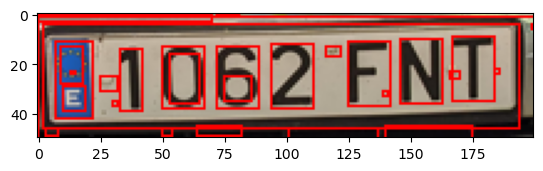

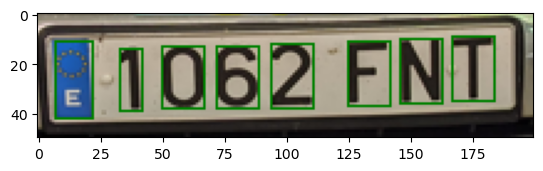

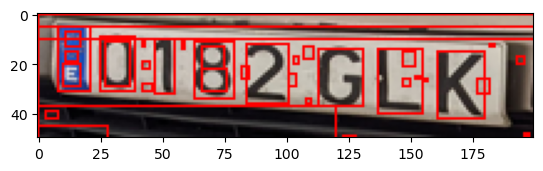

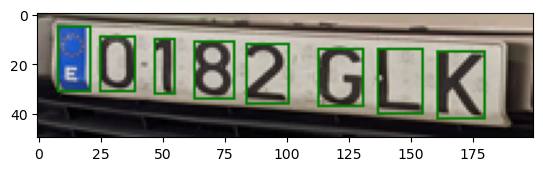

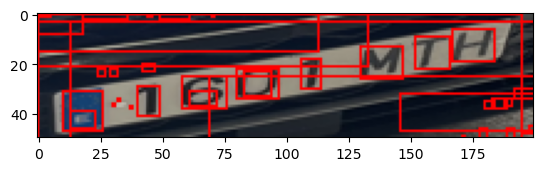

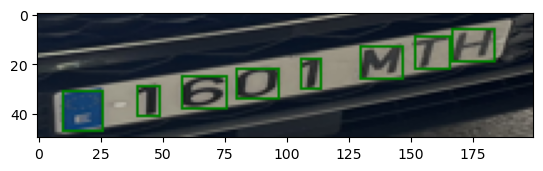

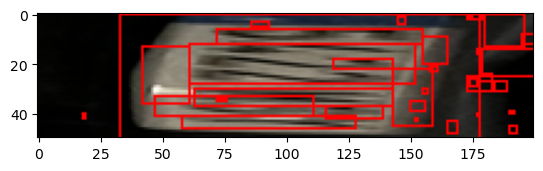

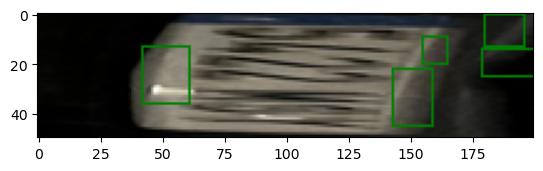

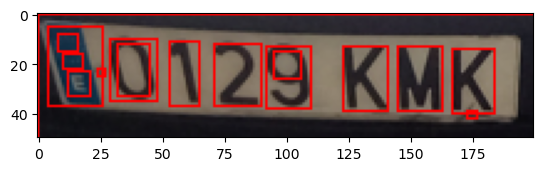

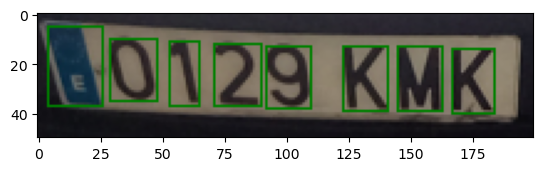

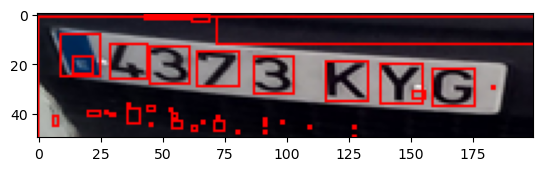

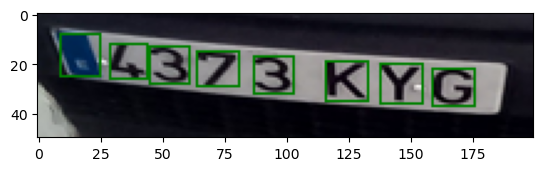

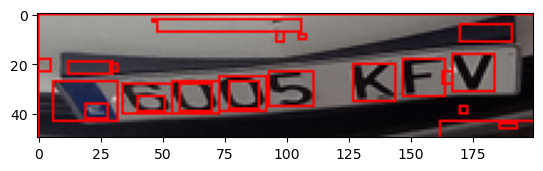

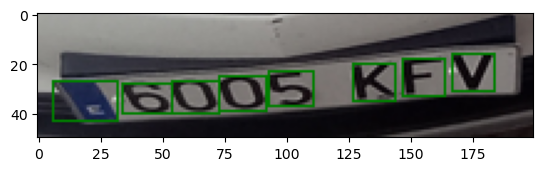

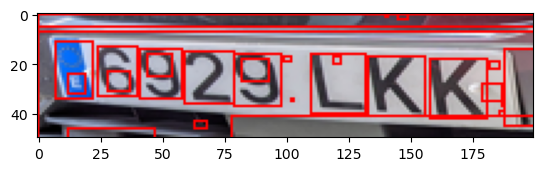

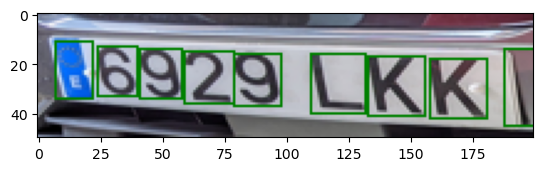

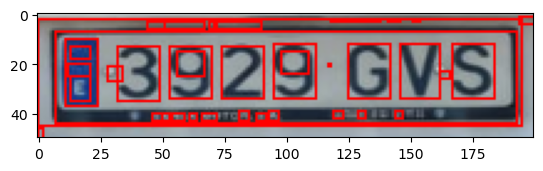

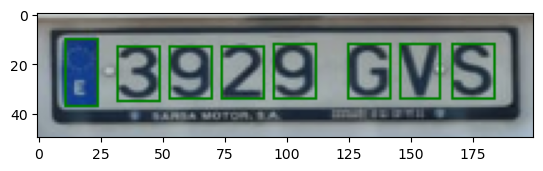

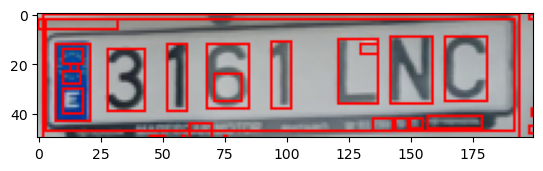

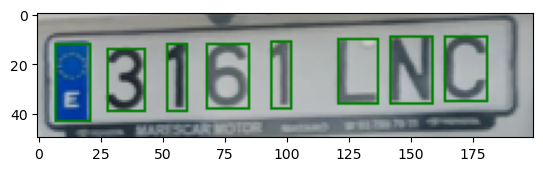

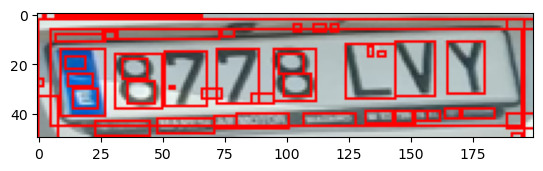

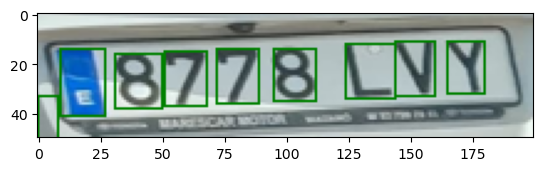

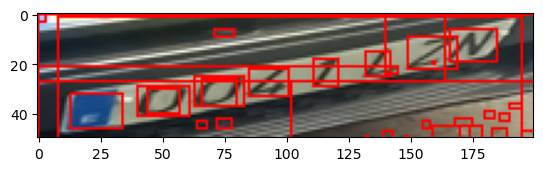

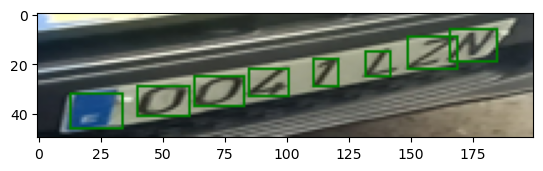

In [12]:
visualize_bounding_boxes(visualizations)

In [8]:
[len(s) for s in segments], [len(s[0]) for s in segments]

([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1], [8, 8, 8, 5, 8, 8, 8, 9, 8, 8, 9, 8])

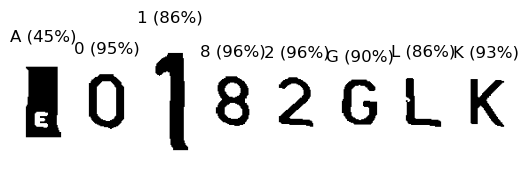

In [9]:
i = 1
fig, ax = plt.subplots(1, len(recognized_characters[i][0]))
for j, (segment, character, confidence, ocr_result, before) in enumerate(recognized_characters[i][0]):
	ax[j].imshow(segment, cmap="gray", vmin=0, vmax=255)
	if character:
		ax[j].set_title(f"{character} ({confidence:.0f}%)")
	else:
		ax[j].set_title("?")
	ax[j].axis("off")
plt.show()

In [10]:
import re
recognized_text = "".join([character for _, character, _, _, _ in recognized_characters[i][0]])
formatted_text = re.sub(r'(?<=\d)(?=[A-Za-z])|(?<=[A-Za-z])(?=\d)', ' ', recognized_text)
formatted_text

'A 0182 GLK'

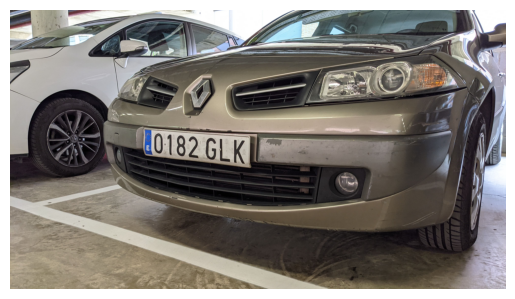

In [11]:
plt.imshow(orig_images[i])
plt.axis("off")
plt.show()